# Objetivo

El objetivo de este notebook de Colab es desarrollar un modelo de machine learning sobre el dataset, a fines de poder predecir valores futuros de la serie temporal elegida, para el proyecto final de la certificación (hackaton)

>08/09/24
>
>Marco Mongi
>
>DS2402

# Introducción a Prophet
Prophet es un algoritmo desarrollado por Facebook para predicción (forecasting) de series temporales.

Entre las **principales características**:
* Es completamente **automático** (no requiere de un experto), aunque permite hacer modificaciones manuales.
* Trabaja mejor con series temporales con **comportamientos periódicos** (periodicidad anual, semanal y diaria). Permite agregar días feriados
* Puede detectar automáticamente **cambios en tendencias** desde los datos
* Robusto a **valores faltantes** en los datos y **outliers**, permite datos no tomados a intervalos regulares

# Introducción al Notebook
En este documento voy a ir poniendo las cuestiones teóricas que considero fundamentales para entender prophet y como funciona, pero la intención no es que sea un resumen teórico sino que la teoría va a complementar la parte práctica, es decir todo el código que hace falta para hacer la predicción, desde la carga y preprocesamiento de datos de la serie temporal al modelo, el entrenamiento, validación y tuning del mismo, la predicción propiamente dicha y los parámetros de evaluación de la performance del modelo.

Algunos links interesantes:
>[Página oficial](https://facebook.github.io/prophet/)
>
>[Paper original](https://peerj.com/preprints/3190/)
>
>[Python API Quick Start](https://facebook.github.io/prophet/docs/quick_start.html#python-api)
>
>[Tutorial prophet con python](https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/)
>
>[Reference Manual (R)](https://cran.r-project.org/web/packages/prophet/prophet.pdf)
>
>[Github](https://github.com/facebook/prophet)

# Importo librerías a usar
Centralizo todos los imports en esta sección, al principio del colab

In [1]:
import pandas as pd
import numpy as np
import prophet
from prophet import Prophet
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Cargo dataset desde Drive
Va a pedir acceso a la cuenta de google
Lo siguiente lee un archivo desde drive, y carga el archivo Dataset.csv en el entorno de ejecución

In [2]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
link='https://drive.google.com/file/d/1NboG0z-qVZuTx0qKMScZFm0UPJt_Do4_'
fluff, id = link.split('d/')
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('processed_dataset.csv')

In [3]:
# Asigno el contenido del csv a un dataframe
df = pd.read_csv('processed_dataset.csv',sep=',')

# Muestro los primeros 20 elementos del dataset (sin procesar)
df.head(20)

date  Consumption  hour  day_of_week  month
0   2006-12-16 17:24:00     4.236671    17            5     12
1   2006-12-16 17:25:00     5.377704    17            5     12
2   2006-12-16 17:26:00     5.397025    17            5     12
3   2006-12-16 17:27:00     5.411335    17            5     12
4   2006-12-16 17:28:00     3.703828    17            5     12
5   2006-12-16 17:29:00     3.558495    17            5     12
6   2006-12-16 17:30:00     3.738342    17            5     12
7   2006-12-16 17:31:00     3.736362    17            5     12
8   2006-12-16 17:32:00     3.703286    17            5     12
9   2006-12-16 17:33:00     3.697343    17            5     12
10  2006-12-16 17:34:00     4.475791    17            5     12
11  2006-12-16 17:35:00     5.432370    17            5     12
12  2006-12-16 17:36:00     5.245823    17            5     12
13  2006-12-16 17:37:00     5.283013    17            5     12
14  2006-12-16 17:38:00     4.075905    17            5     12
15  2006-12-16 17:39:00     3.395730    17            5     12
16  2006-12-16 17:40:00     3.273531    17            5     12
17  2006-12-16 17:41:00     3.433546    17            5     12
18  2006-12-16 17:42:00     3.266000    17            5     12
19  2006-12-16 17:43:00     3.728000    17            5     12

# Preparo dataset
Prophet toma como input un DataFrame de datos de una serie temporal en un formato específico. La primera columna debe llamarse 'ds' y contener las fechas en formato datetime, mientras que la segunda debe llamarse 'y' y contener las observaciones.

In [4]:
# Cambio los nombres de las columnas a los que espera prophet
df.rename(columns={"date": "ds", "Consumption": "y"},inplace=True)

# Convierto date de tipo "object" a "datetime"
df['ds'] =  pd.to_datetime(df['ds'], infer_datetime_format=True)

# Elimino columnas que no uso
df.drop(labels=['hour','day_of_week','month'],axis=1,inplace=True)

# Muestro
df.head()

<ipython-input-4-aa8fa9664bd4>:5: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['ds'] =  pd.to_datetime(df['ds'], infer_datetime_format=True)


ds         y
0 2006-12-16 17:24:00  4.236671
1 2006-12-16 17:25:00  5.377704
2 2006-12-16 17:26:00  5.397025
3 2006-12-16 17:27:00  5.411335
4 2006-12-16 17:28:00  3.703828

**Resampling**

Ya que tener datos a nivel minuto no me aporta mucho, los dejo cada 1 hora

In [5]:
# Resampling
freq='1H'
df=df.resample(freq,on='ds').mean()
df.reset_index(inplace=True)

# Muestro
df.head()

ds         y
0 2006-12-16 17:00:00  4.235039
1 2006-12-16 18:00:00  3.633753
2 2006-12-16 19:00:00  3.401852
3 2006-12-16 20:00:00  3.269883
4 2006-12-16 21:00:00  3.058049

**Elimino outliers**

Como los outliers me pueden afectar a la predicción, y Prophet no tiene problemas con datos faltantes, podría directamente eliminar los posibles outliers usando la función para eliminar por percentil

Dado que desde el EDA definí que no hay outliers, no elimino nada (dejo los límites de los percentiles en 0 y 1)

In [6]:
# Defino función outliers
def elimino_percentil(df,inferior,superior):
    # Le cargo solamente los percentil inferior y superior.
    # Ejemplo: si quiero eliminar valores por debajo del 1% y por encima del 99% le cargo elimino_percentil(df,1,99)
    lower_value = df.y.quantile(inferior) # Percentil 0.1%
    upper_value = df.y.quantile(superior) # Percentil 99.9%
    df.drop(df[(df.y>upper_value)|(df.y<lower_value)].index, axis=0, inplace=True)

    return df

In [7]:
df=elimino_percentil(df,0,1)

df.head()

ds         y
0 2006-12-16 17:00:00  4.235039
1 2006-12-16 18:00:00  3.633753
2 2006-12-16 19:00:00  3.401852
3 2006-12-16 20:00:00  3.269883
4 2006-12-16 21:00:00  3.058049

## Defino parámetros de prophet

A grandes rasgos, hay dos formas de armar modelos predictivos:
* **Predicciones por expertos:** un experto con conocimiento en el fenómeno que se analiza mira la serie temporal y basándose en su conocimiento hace una predicción. Este proceso es manual, requiriendo la labor del o los expertos, y es flexible porque puede adaptarse rápidamente a algún imprevisto.
* **Predicciones estadísticas:** se usa un modelo que analiza la información de la serie temporal y el valor predecido responde a conocimiento estadístico obtenido a partir de la misma (el valor más probable)

**Prophet es una mezcla de los dos**, queriendo tomar lo mejor de cada uno: elabora un modelo estadístico automáticamente a partir de los datos pero además permite al usuario "experto" modificar manualmente algunos parámetros en función de su conocimiento para que el modelo final estime mejor.

En el paper, se indican los **parámetros que el usuario puede modificar** según su conocimiento de experto:
* **Capacidades:** si se conoce el dato de el tamaño total de mercado se puede aplicar este conocimiento directamente como capacidad
* **Changepoints (puntos de cambio):** si se identifica un punto de cambio, se puede cargar a mano
* **Eventos y feriados**
* **Parámetros de smoothing (suavizado)**

### Límites de saturación

Carrying capacity es el **límite máximo de saturación**, o el valor máximo al que puedo llegar. Puedo especificarla manualmente con el código que dejo, es una columna nueva en el dataframe. En el ejemplo se crea un valor constante, pero puedo poner que varíe en el tiempo si lo necesito
>*df['cap'] = 8.5*

Así como este valor de carrying capacity acota la función en un valor máximo, existe también un **límite de saturación inferior**, que lo podemos definir como una columna extra "floor". Si quiero especificar "floor", debo sí o sí especificar "cap".

>*df['floor'] = 1.5*

Por último, si quiero ponerle límites a las funciones a predecir, puedo ponerlos como columnas en el dataframe con las fechas de la siguiente forma:

>*future['cap'] = 6*
>
>*future['floor'] = 1.5*

In [8]:
cap_value = 1.2*np.max(df.y) # Esta la seteo en función de los datos que tengo, por ahí me la puede dar la empresa de energía
floor_value = 0 # Valor mínimo que asumen mis datos

# Defino límites de saturación
df['cap'] = cap_value
df['floor'] = floor_value

# Muestro
df.head()

ds         y       cap  floor
0 2006-12-16 17:00:00  4.235039  7.883225      0
1 2006-12-16 18:00:00  3.633753  7.883225      0
2 2006-12-16 19:00:00  3.401852  7.883225      0
3 2006-12-16 20:00:00  3.269883  7.883225      0
4 2006-12-16 21:00:00  3.058049  7.883225      0

# Sobre el modelo
Prophet modela a la curva de la serie temporal $y(t)$ como la suma de cuatro partes, con la siguiente función:

$y(t)=g(t)+s(t)+h(t)+e_t$

En donde:
* $g(t)$ es la función de **tendencia**, que modela cambios no periódicos en el valor de la serie de datos
* $s(t)$ representa la parte **periódica** (por ejemplo periodicidad semanal y anual)
* $h(t)$ representa los efectos de **feriados y eventos**, que suelen ocurrir irregularmente
* $e_t$ representa el error

Básicamente entonces, Prophet descompone a la serie temporal en distintas funciones, cada una representando una cosa: tendencia, comportamiento periódico, efectos de feriados y error, y la función final es la suma de todas estas.

Se plantea a prophet como una caja negra que entrenamos a partir de datos conocidos de la serie temporal, y el modelo por dentro obtiene la curva que mejor ajusta a los datos (curve fitting) para dar a la salida la predicción.

## Función tendencia $g(t)$
El modelo incorpora dos funciones distintas para modelar la tendencia:
* Crecimiento saturado (no lineal)
* Lineal de a partes

De estas dos curvas, hay que elegir cuál se adapta mejor a la serie de datos temporal que estamos analizando

###Crecimiento saturado (Saturating Growth)
Modela cómo una población ha crecido y cómo se espera que siga creciendo en un ecosistema natural. Esta misma curva puede modelar bien otros escenarios distintos (en el paper hablan de que modela el crecimiento en el número de usuarios en Facebook).

En su **forma básica**, la curva tiene la siguiente fórmula (parecida a una sigmoide):

$g(t)=\frac{C}{1+exp(-k(t-m))}$

Donde:
* C: Carrying capacity
* k: growth rate
* m: offset parameter

El modelo final implementado en prophet tiene algunos extras respecto a esta función, por ejemplo C no es una constante sino que es una función temporal $C(t)$, y k tampoco es constante (para lo cual se implementa una lógica extra con changepoints)

Tener en cuenta que la curva g(t) modela solamente a un pedacito de la serie temporal, entre dos changepoints sucesivos. Para cada uno de estos intervalos se elige la g(t) que mejor ajusta, por eso es "de a partes" (piecewise)

### Lineal(linear)
Como indica el nombre, es una curva lineal, así que se ajusta a la función básica:

$g(t)=k·t+m$

Donde k y m son la tasa de crecimiento y el offset, igual que antes.

La diferencia con la curva que implementa el algoritmo de facebook es que éste último es lineal de a partes (o sea es una curva que se va "cortando" en los changepoints y va cambiando en función de los datos, siendo siempre entre dos changepoints sucesivos una línea recta)

## Función periodicidad $s(t)$
Se modela con una serie de Fourier de la siguiente forma:
$s(t)=\sum_{n=1}^N\ (a_n cos(\frac{2\pi nt}{P})+b_n sin(\frac{2\pi nt}{P}))$
En donde:
* **P**: período que esperamos que la serie tenga (por ejemplo para un año, P=365.25)
* **N**: cantidad de términos de la serie de Fourier que tomemos (si elegimos un valor más alto podemos modelar comportamientos más rápidos o de mayor frecuencia, pero aumentando el riesgo de overfitting. Un valor de N bajo actúa como un filtro pasabajos). Para funciones periódicas anualmente N=10 anda bien, y periodicidad semanal N=3 (según el paper)
* **$a_n$** y **$b_n$**: parámetros de cada componente espectral de la serie de Fourier (los estima el sistema)

> *Nota: en el paper dice que $a_n$ y $b_n$ están normalmente distribuidos o algo así, para que sea como un filtro suavizante (smoothing), no entendí por qué dice eso si supuestamente el sistema lo calcula, no debería imponer una distribución, pero a lo mejor entendí mal*

## Función feriados y eventos $h(t)$
La función h(t) es básicamente una lista que indica la fecha en la que ocurre el evento, cada elemento ponderado por una constante.

Según interpreto, feriados y eventos rompen la periodicidad porque en estas fechas cambia el comportamiento de la gente, así que se tienen en cuenta. El paper habla de que cada evento se pondera por un valor constante, calculo q para "acomodarlo" y que su efecto en la curva sea el mismo que si no fuera feriado.

Como cada evento tiene distintas características (ejemplo durante Navidad las personas se reúnen a comer a la noche, y en el día de la bandera no) se identifica a cada evento particular con un nombre único (ejemplo: Navidad) y el año en el que ocurre. La idea detrás es que el comportamiento va a ser parecido a lo largo de los años para un mismo evento.

Por otra parte, en los días alrededor de un evento suele haber también un cambio en el comportamiento (ejemplo compras navideñas en los días previos al 25-dic), por lo que el sistema toma una ventana de tiempo alrededor del evento y los trata también como si fueran eventos, incluyéndolos en h(t).

# Defino el modelo
Para usar Prophet para forecasting, primero se crea y configura un objeto Prophet(). Luego, este objeto es entrenado con el dataset llamando a la función fit() y pasandole los datos (en el formato adecuado)

El objeto Prophet() toma argumentos para configurar el tipo de modelo deseado, como el tipo de crecimiento, tipo de periodicidad, y más. Por defecto, el modelo buscará configurar todos estos parámetros automáticamente.

## Ejemplo definición de modelo automática (caso más simple)
La idea es que Prophet sea simple de usar, y ya los parámetros de entrada funcionen más o menos bien independientemente del dataset que le cargue (aunque si el que lo ejecuta sabe sobre el modelo, puede tocar parámetros más específicos para que el modelo se adapte mejor al dataset, ya lo vamos a ir viendo a lo largo del Notebook)

In [9]:
# AUTOMÁTICO: Defino el modelo
model = prophet.Prophet() # Si no le paso parámetros, el modelo busca automáticamente los que estima mejores

## Ejemplo definición de modelo manual
Le puedo pasar parámetros más adecuados al dataset que estoy analizando si sé que tocar. Dejo acá todo como para modificar, explicando que hace cada cosa.

In [10]:
# MANUAL: Defino el modelo
growth='linear' # Puede ser 'linear' o 'logistic' según la función de crecimiento que quiera (afecta función trend)
changepoints = None # Lista de fechas con changepoints. Si pongo None se buscan automáticamente
n_changepoints = 25 # Cantidad de changepoints (si le paso lista lo saca de ahí, tiene sentido en caso que no pase lista)
changepoint_range = 0.8 # Proporción de los datos de entrenamiento en los que se van a buscar changepoints (0,8 para 80% del dataset)
yearly_seasonality = 'auto' # Puede ser 'auto', True, False o un número de términos de Fourier a generar
weekly_seasonality = 'auto' # Idem anterior
daily_seasonality = 'auto' # Idem anterior
holidays = None # pd.DataFrame with columns holiday (string) and ds (date type)
seasonality_mode = 'additive' # 'additive' (default) or 'multiplicative'
seasonality_prior_scale = 10.0 # Parameter modulating the strength of the seasonality model
holidays_prior_scale = 10.0 # Parameter modulating the strength of the holiday components model, unless overridden in the holidays input
changepoint_prior_scale = 0.05 # Parameter modulating the flexibility of the automatic changepoint selection
mcmc_samples = 0 # Integer, if greater than 0, will do full Bayesian inference with the specified number of MCMC samples. If 0, will do MAP estimation
interval_width = 0.8 # width of the uncertainty intervals provided for the forecast
uncertainty_samples = 1000 # Number of simulated draws used to estimate uncertainty intervals
stan_backend = None # str as defined in StanBackendEnum default: None - will try to iterate over all available backends and find the working one

model = prophet.Prophet(growth=growth,
                          changepoints=changepoints,
                          n_changepoints=n_changepoints,
                          changepoint_range=changepoint_range,
                          yearly_seasonality=yearly_seasonality,
                          weekly_seasonality=weekly_seasonality,
                          daily_seasonality=daily_seasonality,
                          holidays=holidays,
                          seasonality_mode=seasonality_mode,
                          seasonality_prior_scale=seasonality_prior_scale,
                          holidays_prior_scale=holidays_prior_scale,
                          changepoint_prior_scale=changepoint_prior_scale,
                          mcmc_samples=mcmc_samples,
                          interval_width=interval_width,
                          uncertainty_samples=uncertainty_samples,
                          stan_backend=stan_backend
                          )

## Definición de modelo para entrenar
Desde el análisis exploratorio de los datos, sabemos que hay una fuerte componente de periodicidad diaria, anual y cada medio día. La semanal no es tan importante

Por otro lado, sabemos que el dataset contiene el consumo eléctrico de una vivienda en Francia, por lo cual agregamos los feriados de dicha localidad.

**Seasonality**

Prophet tiene atención a distintas ventanas temporales, es decir que hace un análisis de como se comporta la curva en una ventana de duración igual a un año, otro análisis pero para una ventana de un mes, de una semana y de un día, por poner algunos ejemplos. De esos análisis saca una especie de curva "promedio" y la modela usando una serie de Fourier de N términos. **Con mayor N podemos modelar fenómenos que cambian más rápido, pero corremos riesgo de overfitting porque perderíamos generalidad modelando ruido**.

Así, si tenemos suficientes datos en el dataset, y éste representa una curva con comportamientos periódicos en una ventana temporal de un año por ejemplo (imaginemos los hábitos de consumo de electricidad a lo largo de un año, en donde siempre en verano se consume más por los aires acondicionados). Para este caso particular, el análisis que hace prophet en la ventana de un año va a dar una curva que modele bastante bien los hábitos de consumo.

Por otra parte, si sabemos de donde vienen los datos y conocemos que no tiene periodicidad en una ventana de una semana, por ejemplo, no tiene sentido que prophet modele esta curva, y se puede dejarla fuera del análisis.

In [11]:
model = Prophet(daily_seasonality=15, yearly_seasonality=10, weekly_seasonality=False) # Defino parámetros del modelo, y las componentes de serie de Fourier que van a tener las seasonality que me interesan

**Seasonality Custom**

Puedo no usar una seasonality seteada por defecto, o activar otra al definir el modelo.

Si quiero agregar una seasonality custom (ejemplo trimestral) uso la función add_seasonality y en period establezco la duración en días que quiero cargarle (puede ser flotante para periodos menores a un dia), así como la cantidad de términos de la serie de Fourier. Esta nueva seasonality se carga como un componente nuevo si vemos el gráfico de componentes

Del EDA sabemos que hay una componente periódica cada medio dia

In [12]:
model.add_seasonality(name='half_day', period=0.5, fourier_order=5)

**Carga de feriados automática por país**

Facilita bastante cargar feriados, se le pasa a la función add_country_holidays el identificador del país al que pertenecen los datos de nuestro dataset (Argentina: 'AR', Estados Unidos: 'US', el resto de códigos se puede ver en este [link](https://github.com/dr-prodigy/python-holidays))

>En Python, la mayoría de los días festivos se calculan de forma determinista y, por tanto, están disponibles para cualquier intervalo de fechas; se emitirá una advertencia si las fechas quedan fuera del intervalo admitido por ese país.

In [13]:
model.add_country_holidays(country_name='FR') # Agrego los feriados de Francia, que es desde donde viene el dataset

# Entrenamiento del modelo (todo el dataset)
Esta sección, junto con las predicciones siguientes, son con un modelo entrenado con TODO el dataset. La idea es primero entender el funcionamiento de Prophet, y luego hacer lo que realmente se haría en la práctica para validar el entrenamiento (train / test split)

In [14]:
# Ajuste del modelo
model.fit(df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmptoxczws6/tsr5lo4l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptoxczws6/6lrrg3de.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65291', 'data', 'file=/tmp/tmptoxczws6/tsr5lo4l.json', 'init=/tmp/tmptoxczws6/6lrrg3de.json', 'output', 'file=/tmp/tmptoxczws6/prophet_modelkc_aaosv/prophet_model-20240915212746.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:27:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:28:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


# Predicciones
Tener en cuenta que se entrenó el modelo con todo el dataset hasta este punto

## Predicción "dentro de la muestra" (In-sample)
Puede ser útil hacer una predicción sobre los datos históricos para tener una idea de qué tan bueno es el modelo.

Tener en cuenta que al entrenarlo, el modelo ya vio los valores reales de la serie temporal para la fecha que le pasemos, así que estaría "haciendo trampa" porque lo que predice ya conoce de antemano lo que vale.

La cuestión es que esto no es tan así, ya que el modelo ajusta una curva para los datos que tiene y el valor predecido es un punto en esa curva, que puede no ser exactamente igual al valor real. Así, el modelo bien entrenado puede generalizar y no tener overfitting.

**Uso de la función make_future_dataframe**

```
m.make_future_dataframe(periods, freq = "day", include_history = TRUE)
```
>Arguments
* m: Prophet model object.
* periods: Int number of periods to forecast forward.
* freq: ’day’, ’week’, ’month’, ’quarter’, ’year’, 1(1 sec), 60(1 minute) or 3600(1 hour).
* include_history: Boolean to include the historical dates in the data frame for predictions.

In [15]:
# Crear un dataframe para las predicciones futuras
future = model.make_future_dataframe(periods=24*30, freq=freq, include_history=True)  # Suponiendo que queremos predecir el próximo mes (dado freq=1H, 1 mes es 24h*30dias aprox)

Este DataFrame se pasa como input a la función predict() para hacer la predicción.

In [16]:
# use the model to make a forecast
forecast = model.predict(future)

In [17]:
forecast.head()

ds     trend  yhat_lower  yhat_upper  trend_lower  \
0 2006-12-16 17:00:00  1.418843    0.800209    2.661447     1.418843   
1 2006-12-16 18:00:00  1.418713    1.068989    2.827741     1.418713   
2 2006-12-16 19:00:00  1.418583    1.453808    3.290380     1.418583   
3 2006-12-16 20:00:00  1.418454    1.615989    3.481255     1.418454   
4 2006-12-16 21:00:00  1.418324    1.559222    3.406201     1.418324   

   trend_upper  All Saints' Day  All Saints' Day_lower  All Saints' Day_upper  \
0     1.418843              0.0                    0.0                    0.0   
1     1.418713              0.0                    0.0                    0.0   
2     1.418583              0.0                    0.0                    0.0   
3     1.418454              0.0                    0.0                    0.0   
4     1.418324              0.0                    0.0                    0.0   

   Armistice Day  ...  holidays  holidays_lower  holidays_upper    yearly  \
0            0.0  ...       0.0             0.0             0.0  0.304960   
1            0.0  ...       0.0             0.0             0.0  0.305246   
2            0.0  ...       0.0             0.0             0.0  0.305532   
3            0.0  ...       0.0             0.0             0.0  0.305818   
4            0.0  ...       0.0             0.0             0.0  0.306105   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.304960      0.304960                   0.0   
1      0.305246      0.305246                   0.0   
2      0.305532      0.305532                   0.0   
3      0.305818      0.305818                   0.0   
4      0.306105      0.306105                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  1.691745  
1                         0.0                         0.0  1.956748  
2                         0.0                         0.0  2.360672  
3                         0.0                         0.0  2.521980  
4                         0.0                         0.0  2.496460  

[5 rows x 58 columns]

El resultado de la función predict() es un DataFrame que contiene muchas columnas. Quizá las más importantes sean la fecha y hora de la predicción ('ds'), el valor previsto ('yhat'), y los límites inferior y superior del valor previsto ('yhat_lower' y 'yhat_upper') que proporcionan la incertidumbre de la predicción.

In [18]:
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

                   ds      yhat  yhat_lower  yhat_upper
0 2006-12-16 17:00:00  1.691745    0.800209    2.661447
1 2006-12-16 18:00:00  1.956748    1.068989    2.827741
2 2006-12-16 19:00:00  2.360672    1.453808    3.290380
3 2006-12-16 20:00:00  2.521980    1.615989    3.481255
4 2006-12-16 21:00:00  2.496460    1.559222    3.406201


Prophet también proporciona una herramienta integrada para visualizar la predicción en el contexto del conjunto de datos de entrenamiento.

Esto puede lograrse llamando a la función plot() en el modelo y pasándole un DataFrame de resultados. Creará un gráfico del conjunto de datos de entrenamiento y superpondrá la predicción con los límites superior e inferior de las fechas de predicción. En el gráfico, podemos ver que los datos de entrenamiento se representan como puntos negros y la predicción es una línea azul con límites superior e inferior en un área sombreada azul.

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


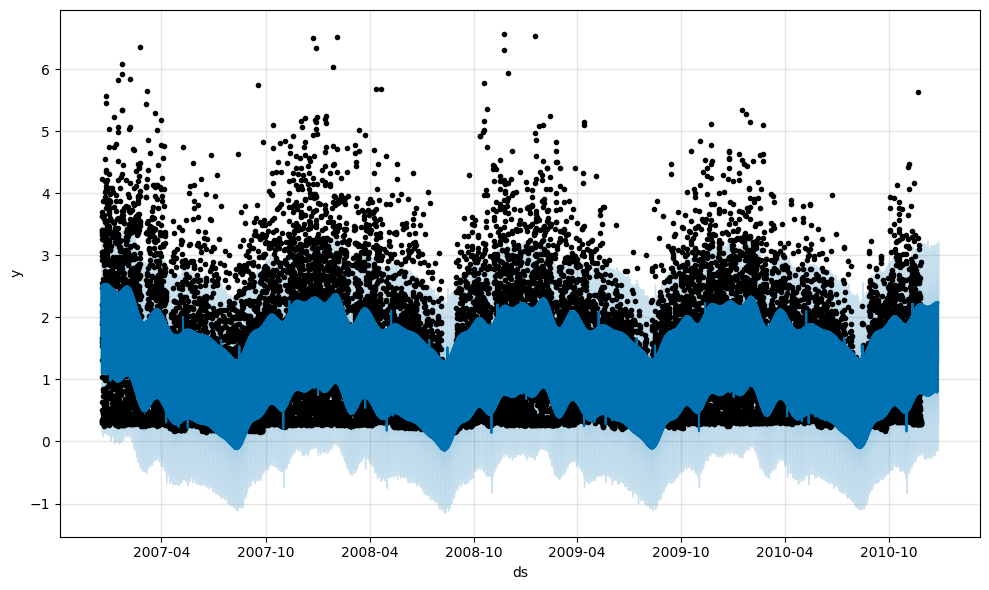

In [19]:
# plot forecast
model.plot(forecast)
plt.show()

## Predicción "fuera de la muestra" (Out-of-sample)
En la práctica, lo que realmente queremos es que un modelo de predicción haga una predicción más allá de los datos de entrenamiento.

Esto se llama una predicción fuera de la muestra.

Una predicción se hace llamando a la función predict() y pasando un DataFrame que contiene una columna llamada 'ds' y filas con datetimes de las fechas a predecir.

Podemos conseguirlo de la misma manera que una predicción dentro de la muestra y simplemente especificar un periodo de predicción diferente.

In [20]:
# Crear un dataframe para las predicciones futuras
future = model.make_future_dataframe(periods=24*30, freq=freq, include_history=False)  # Suponiendo que queremos predecir wl próximo mes (dado freq=1H, 1 mes es 24h*30dias aprox)

In [21]:
future['cap'] = cap_value
future['floor'] = floor_value

In [22]:
future.head()

ds       cap  floor
0 2010-11-26 22:00:00  7.883225      0
1 2010-11-26 23:00:00  7.883225      0
2 2010-11-27 00:00:00  7.883225      0
3 2010-11-27 01:00:00  7.883225      0
4 2010-11-27 02:00:00  7.883225      0

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` o

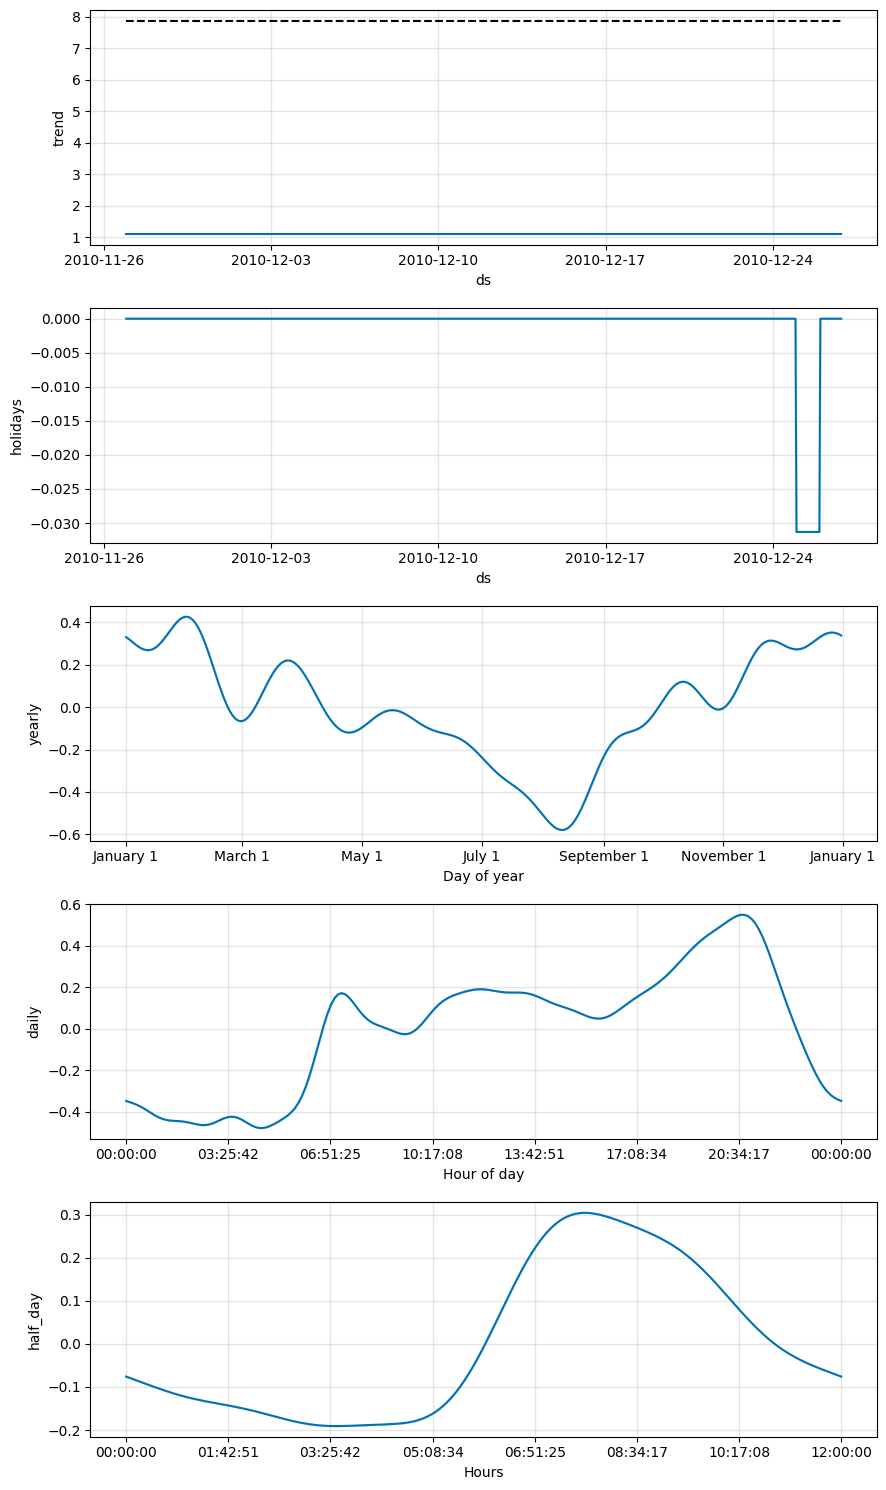

In [23]:
# Hacer predicciones
forecast = model.predict(future)

# Visualizar las predicciones
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

# También puedes visualizar los componentes de la serie temporal
fig = model.plot_components(forecast)

# Entrenamiento del modelo con división train/test
Acá el proceso típico de dividir el dataset en dos partes: train y test, entrenar al modelo con datos de train y evaluar qué tan buena es la predicción que hace el modelo entrenado comparando el valor predecido con el real desde test

Prophet ya incluye herramientas para hacer validación cruzada, y para tuning de hiperparámetros

>No encontré forma de usar las herramientas de sklearn con el modelo de prophet, que me hubiera gustado hacerlo así porque es más flexible. Igual me parece que con las que trae incluidas prophet es suficiente.

## Método tradicional: Train/test split

El dataset tiene fechas que van entre estas dos fechas:

16-dic-2006 17:00hs

26-nov-2010 21:00hs

Voy a hacer el split el 1 de enero de 2010 (me da una división del 77% del dataset para test, y me permite predecir un año entero)

In [24]:
# Defino función para hacer el split en base a fecha
def train_test_split_from_date(df, split_date):
    N=df.index[df['ds'] == split_date][0]
    train = df[:N]
    test = df[N:]
    return train, test

In [25]:
# Hago el split
split_date = '2010-01-01 00:00:00'
train, test = train_test_split_from_date(df,split_date)

In [26]:
print(f"train shape: {train.shape[0]}")
print(f"test shape: {test.shape[0]}")
print("*********")
print(f"train last value: {train.iloc[-1].ds}")
print(f"test first value: {test.iloc[0].ds}")

train shape: 26671
test shape: 7918
*********
train last value: 2009-12-31 23:00:00
test first value: 2010-01-01 00:00:00


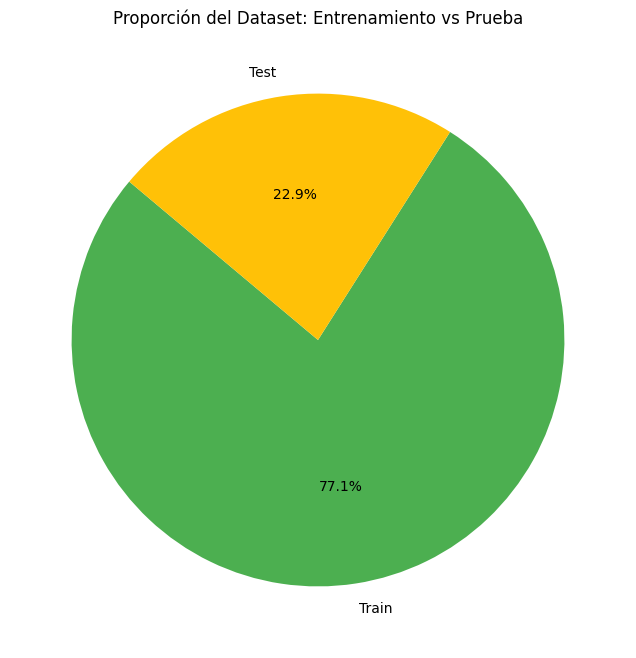

In [27]:
# Calcular los tamaños
size_train = len(train)  # Tamaño del conjunto de entrenamiento
size_test = len(test)     # Tamaño del conjunto de prueba
total_size = size_train + size_test       # Tamaño total del dataset

# Proporciones para el gráfico
proportions = [size_train / total_size, size_test / total_size]

# Etiquetas para el gráfico
labels = ['Train', 'Test']

# Crear el gráfico de torta
plt.figure(figsize=(8, 8))
plt.pie(proportions, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#4CAF50', '#FFC107'])
plt.title('Proporción del Dataset: Entrenamiento vs Prueba')
plt.show()

In [28]:
# Defino el modelo
model = Prophet(daily_seasonality=15, yearly_seasonality=10, weekly_seasonality=False) # Defino parámetros del modelo, y las componentes de serie de Fourier que van a tener las seasonality que me interesan
model.add_seasonality(name='half_day', period=0.5, fourier_order=5)
model.add_country_holidays(country_name='FR') # Agrego los feriados de Francia, que es desde donde viene el dataset

In [29]:
# Entreno el modelo
model.fit(train)

DEBUG:cmdstanpy:input tempfile: /tmp/tmptoxczws6/zb_dna_a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptoxczws6/olx7jfmy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=111', 'data', 'file=/tmp/tmptoxczws6/zb_dna_a.json', 'init=/tmp/tmptoxczws6/olx7jfmy.json', 'output', 'file=/tmp/tmptoxczws6/prophet_modelmk1ph1_f/prophet_model-20240915212845.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:28:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:29:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [30]:
# Hago prediccion para las fechas de test
forecast = model.predict(pd.DataFrame(test['ds']))

**Evaluo**

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def evaluar_modelo_prophet(modelo, train_data, test_data, horizontes):
    """
    Evalúa el modelo Prophet en diferentes horizontes temporales.

    Parámetros:
    - modelo: objeto Prophet ya entrenado.
    - train_data: DataFrame con los datos de entrenamiento (columnas 'ds' y 'y').
    - test_data: DataFrame con los datos de prueba (columnas 'ds' y 'y').
    - horizontes: lista de strings que indican los horizontes temporales (por ejemplo, ['1D', '1W', '1M']).

    Retorna:
    - Diccionario con el MSE para cada horizonte.
    """
    resultados = {}

    for horizonte in horizontes:
        # Determinar el número de períodos a predecir según el horizonte
        if horizonte == '1D':
            periods = 24  # 24 horas
            delta = pd.Timedelta(days=1)
        elif horizonte == '1W':
            periods = 7 * 24  # 7 días
            delta = pd.Timedelta(weeks=1)
        elif horizonte == '1M':
            periods = 30 * 24  # Aproximadamente 1 mes
            delta = pd.Timedelta(days=30)
        elif horizonte == '3M':
            periods = 90 * 24  # Aproximadamente 3 meses
            delta = pd.Timedelta(days=90)
        elif horizonte == '6M':
            periods = 180 * 24  # Aproximadamente 6 meses
            delta = pd.Timedelta(days=180)
        elif horizonte == 'test completo':
            periods = len(test_data)
            delta = test_data['ds'].iloc[-1] - train_data['ds'].iloc[-1]
        else:
            print(f"Horizonte {horizonte} no reconocido.")
            continue

        # Generar fechas futuras para predecir
        future = modelo.make_future_dataframe(periods=periods, freq='H')

        # Realizar predicciones
        forecast = modelo.predict(future)

        # Filtrar las predicciones para el horizonte actual
        inicio_prediccion = train_data['ds'].iloc[-1]
        fin_prediccion = inicio_prediccion + delta

        forecast_horizon = forecast[(forecast['ds'] > inicio_prediccion) & (forecast['ds'] <= fin_prediccion)]

        # Obtener los valores reales correspondientes
        actual = test_data[(test_data['ds'] > inicio_prediccion) & (test_data['ds'] <= fin_prediccion)]

        # Asegurarse de que los índices coinciden
        actual = actual.reset_index(drop=True)
        forecast_horizon = forecast_horizon.reset_index(drop=True)

        # Calcular el MSE
        mse = mean_squared_error(actual['y'], forecast_horizon['yhat'])
        resultados[horizonte] = mse

        # Graficar los valores predichos y reales
        plt.figure(figsize=(12, 6))
        plt.plot(actual['ds'], actual['y'], label='Valor Real')
        plt.plot(forecast_horizon['ds'], forecast_horizon['yhat'], label='Predicción')
        plt.xlabel('Fecha')
        plt.ylabel('Consumo de Energía')
        plt.title(f'Predicción vs Real - Horizonte: {horizonte}')
        plt.legend()
        plt.show()

        print(f"MSE para el horizonte {horizonte}: {mse:.4f}")

    return resultados


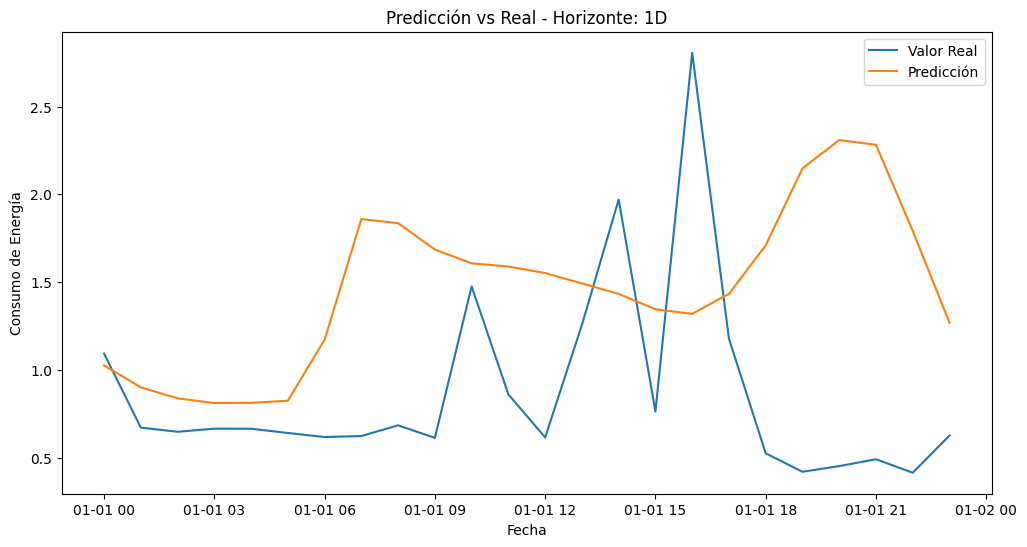

MSE para el horizonte 1D: 0.9258


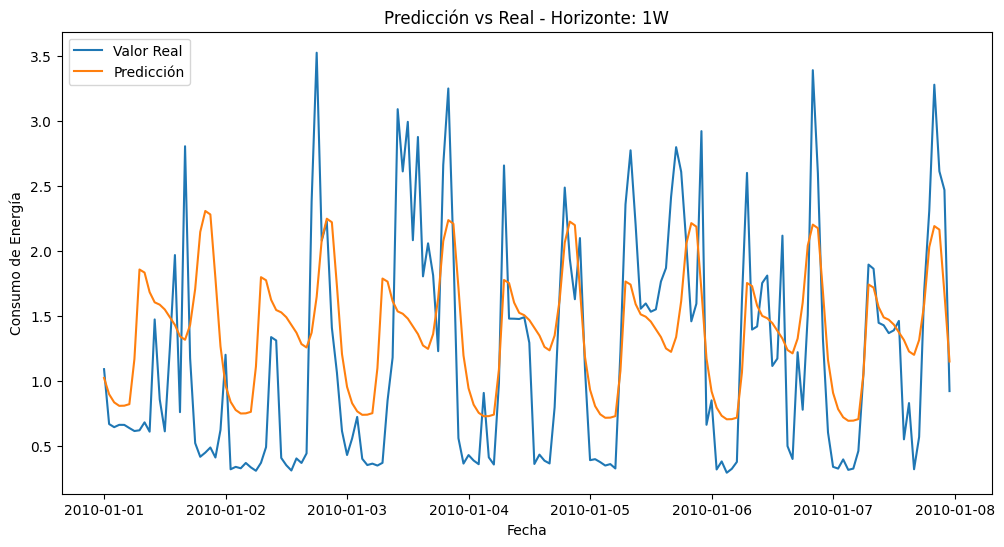

MSE para el horizonte 1W: 0.5176


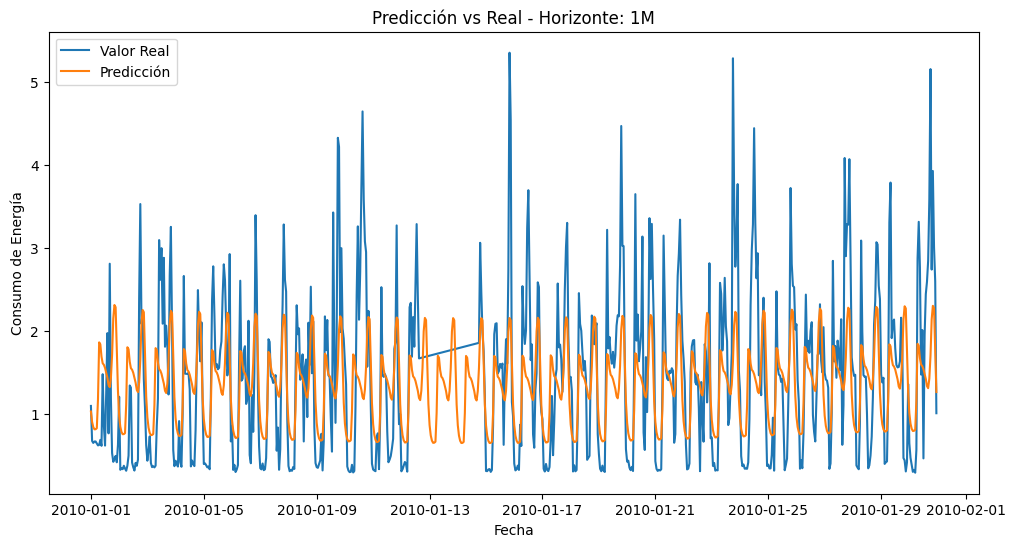

MSE para el horizonte 1M: 0.6093


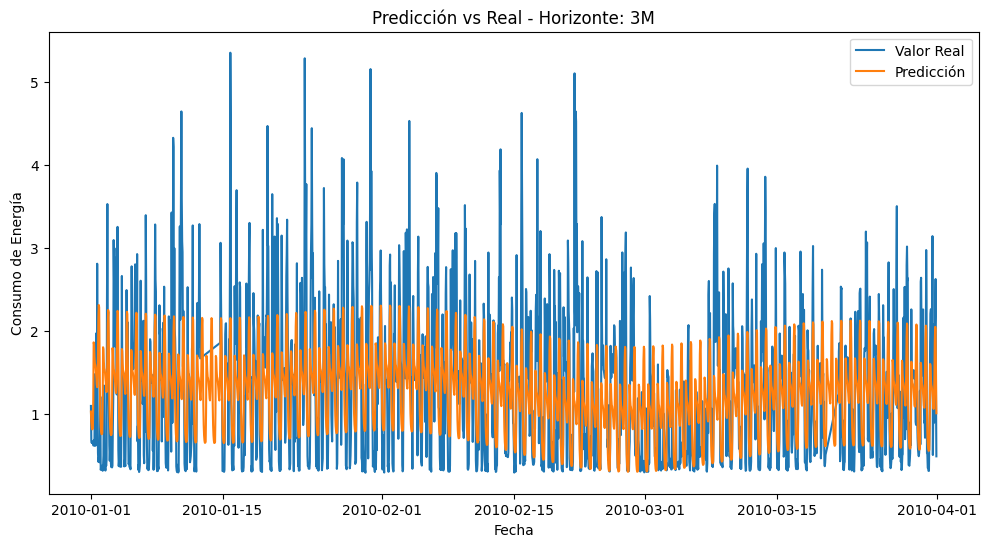

MSE para el horizonte 3M: 0.5036


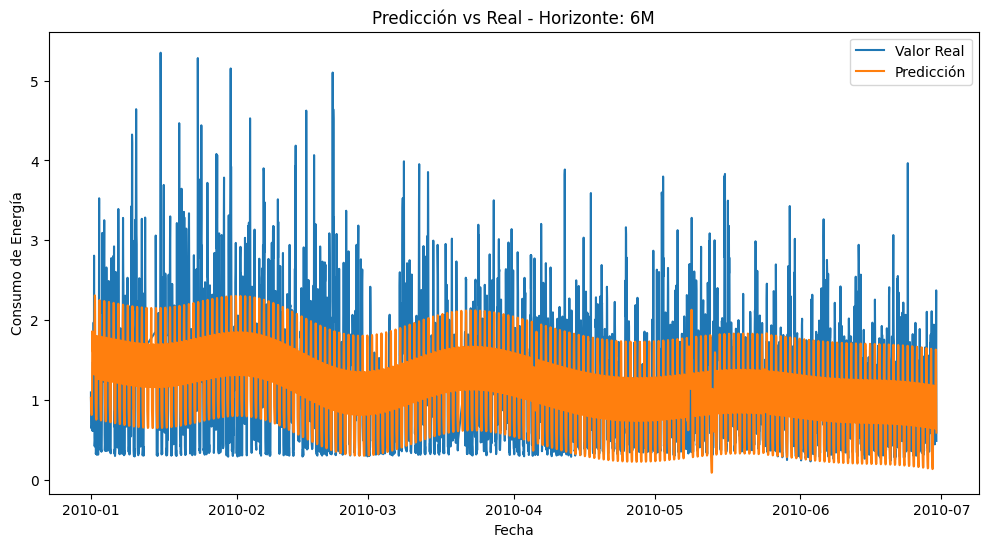

MSE para el horizonte 6M: 0.4377


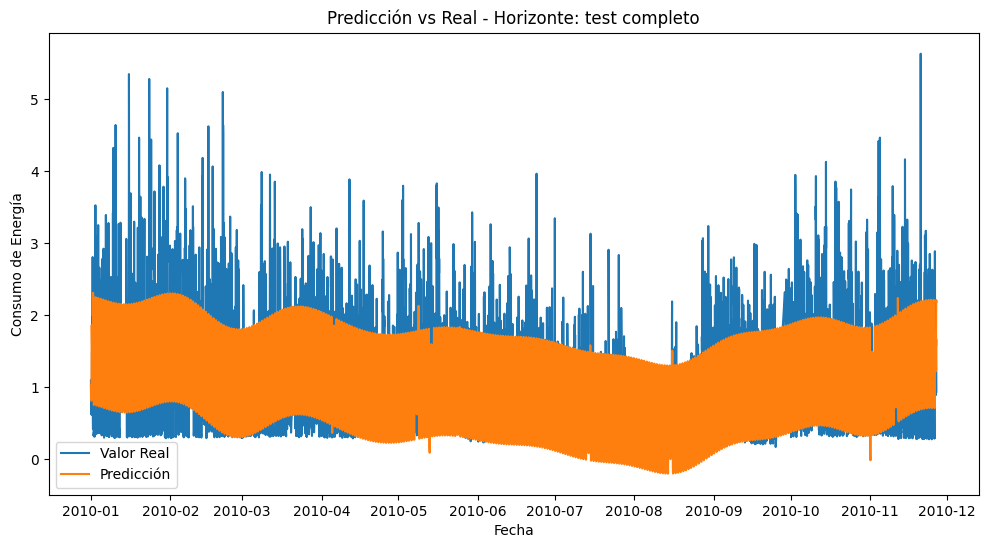

MSE para el horizonte test completo: 0.4203
Resultados de MSE por horizonte:
1D: 0.9258
1W: 0.5176
1M: 0.6093
3M: 0.5036
6M: 0.4377
test completo: 0.4203


In [32]:
# Lista de horizontes a evaluar
horizontes = ['1D', '1W', '1M', '3M', '6M', 'test completo']

# Llamar a la función con tus datos
resultados = evaluar_modelo_prophet(model, train, test, horizontes)

# Mostrar los resultados
print("Resultados de MSE por horizonte:")
for horizonte, mse in resultados.items():
    print(f"{horizonte}: {mse:.4f}")


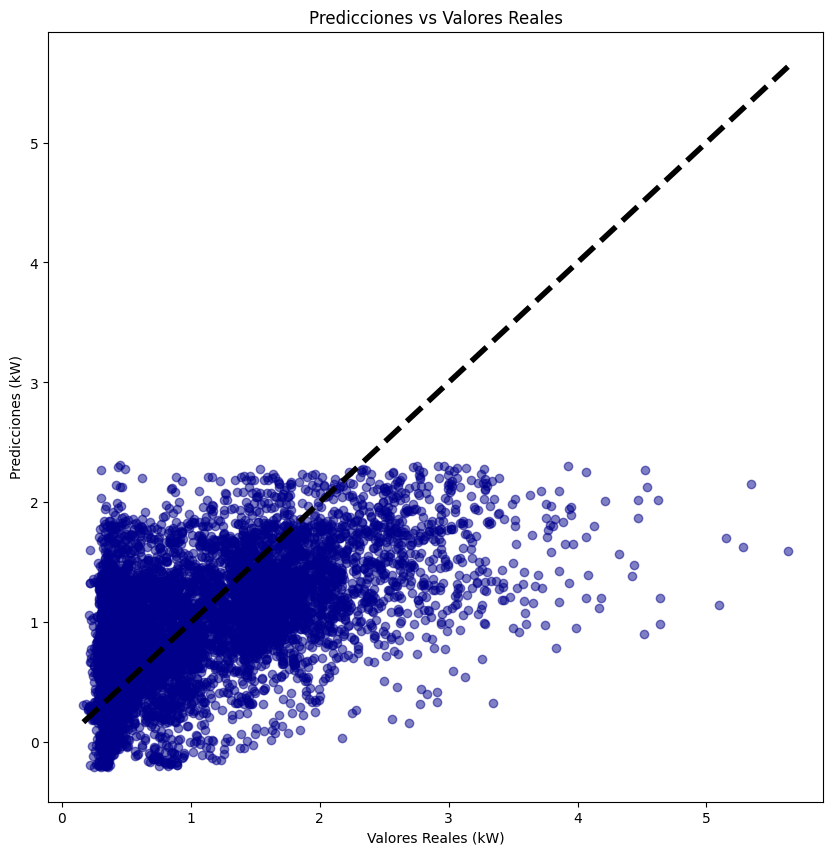

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(test.y, forecast.yhat, alpha=0.5, color='darkblue')
plt.title('Predicciones vs Valores Reales')
plt.xlabel('Valores Reales (kW)')
plt.ylabel('Predicciones (kW)')
plt.plot([test.y.min(), test.y.max()], [test.y.min(), test.y.max()], 'k--', lw=4)
plt.show()

In [33]:
# Calculamos diferentes métricas de error
mse = mean_squared_error(test.y, forecast.yhat)
mae = mean_absolute_error(test.y, forecast.yhat)
mape = mean_absolute_percentage_error(test.y, forecast.yhat)

print(f"Error Cuadrático Medio (MSE): {mse}")
print(f"Error Absoluto Medio (MAE): {mae}")
print(f"Error Porcentual Absoluto Medio (MAPE): {mape}")

Error Cuadrático Medio (MSE): 0.420325990049816
Error Absoluto Medio (MAE): 0.48721402034465267
Error Porcentual Absoluto Medio (MAPE): 0.6272790383700999


## Validación cruzada (Cross Validation)
Se definen **tres parámetros**:
* **initial:** la cantidad inicial de días con la que voy a entrenar al modelo
* **horizon:** la cantidad de días desde donde terminan las muestras de entrenamiento en las que voy a hacer predicción
* **period:** cantidad de días que, por cada iteración de cross validation, agrego al dataset de entrenamiento.

El **proceso** es así, para un ejemplo con initial=1825, horizon=60 y period=30:
1. Se entrena al modelo con los primeros 1825 días (initial)
2. Se predicen los siguientes 60 días (1826 a 1885)
3. Se calculan las métricas de performance en función del valor real contra el predecido para esos 60 días
4. Se pasa a la siguiente iteración de cross-validation. Se entrena al modelo con 1825 (initial) días, pero arrancando 30 (period) días después de la primera muestra y terminando en period (1825) + 30 días = 1855 días (en definitiva es una ventana de tamaño "initial" que en cada iteración se mueve "period" hacia la derecha).
5. Se predicen los siguientes 60 días (1856 a 1915)
6. Se calculan las métricas de performance
7. Repito los pasos 4-6 hasta que llego al final del dataset, aumentando la cantidad de datos de entrenamiento en 30 días (period) por cada iteración.

> Puedo pasar las fechas en las que se hacen los cutoffs (donde cae el period en cada iteración) manualmente, como una lista de fechas

Si quiero **paralelizar** la validación cruzada, puedo pasar alguno de los siguientes parámetros:
* parallel=None (Default, no parallelization)
* parallel="processes" (anda bien para datasets no tan grandes)
* parallel="threads"
* parallel="dask" (para datasets gigantes, dask hace una red de equipos que se distribuyen la carga, pero hay que tener los equipos y configurarlos, encima usando otra librería)

In [ ]:
df_cv = prophet.diagnostics.cross_validation(model, initial='730 days', period='30 days', horizon = '60 days', parallel='processes')

INFO:prophet:Making 11 forecasts with cutoffs between 2009-01-05 23:00:00 and 2009-11-01 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f61d15d5150>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjre7c57c/__1awtks.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjre7c57c/1lci2tbf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjre7c57c/0fyk65wb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91805', 'data', 'file=/tmp/tmpjre7c57c/1lci2tbf.json', 'init=/tmp/tmpjre7c57c/0fyk65wb.json', 'output', 'file=/tmp/tmpjre7c57c/prophet_modelvc3o_b65/prophet_model-20240915123648.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:36:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjre7c57c/d8zfbl6h.json
DE

In [ ]:
df_cv

ds      yhat  yhat_lower  yhat_upper         y  \
0     2009-01-06 00:00:00  0.829244   -0.257629    1.819857  0.335907   
1     2009-01-06 01:00:00  0.682476   -0.281577    1.731219  0.321080   
2     2009-01-06 02:00:00  0.607180   -0.414527    1.624898  1.016208   
3     2009-01-06 03:00:00  0.574496   -0.385143    1.561934  0.398341   
4     2009-01-06 04:00:00  0.572403   -0.369634    1.663356  0.331308   
...                   ...       ...         ...         ...       ...   
15835 2009-12-31 19:00:00  2.213510    1.233989    3.147619  3.069111   
15836 2009-12-31 20:00:00  2.384519    1.395362    3.367527  2.848497   
15837 2009-12-31 21:00:00  2.374093    1.396815    3.359435  2.884643   
15838 2009-12-31 22:00:00  1.891847    0.908652    2.836302  2.041765   
15839 2009-12-31 23:00:00  1.373975    0.399628    2.305964  1.695910   

                   cutoff  
0     2009-01-05 23:00:00  
1     2009-01-05 23:00:00  
2     2009-01-05 23:00:00  
3     2009-01-05 23:00:00  
4     2009-01-05 23:00:00  
...                   ...  
15835 2009-11-01 23:00:00  
15836 2009-11-01 23:00:00  
15837 2009-11-01 23:00:00  
15838 2009-11-01 23:00:00  
15839 2009-11-01 23:00:00  

[15840 rows x 6 columns]

**Métricas de performance**

Puedo evaluar que tan buena fue la predicción en los días dentro de "horizon" con alguno de los siguientes estadísticos:
* error medio cuadrático (MSE)
* error medio cuadrático (RMSE)
* error medio absoluto (MAE)
* error medio porcentual absoluto (MAPE)
* error medio porcentual absoluto (MDAPE)
* cobertura de las estimaciones yhat_lower y yhat_upper

Prophet devuelve un dataframe con todos estos estadísticos

In [ ]:
df_p = prophet.diagnostics.performance_metrics(df_cv)
df_p.head()

horizon       mse      rmse       mae      mape     mdape     smape  \
0 6 days 00:00:00  0.418440  0.646869  0.477785  0.657306  0.417330  0.501304   
1 6 days 01:00:00  0.417913  0.646462  0.477302  0.656680  0.416570  0.501169   
2 6 days 02:00:00  0.416867  0.645653  0.476823  0.657136  0.416062  0.500791   
3 6 days 03:00:00  0.417708  0.646303  0.477571  0.658535  0.417330  0.501756   
4 6 days 04:00:00  0.418074  0.646586  0.478030  0.659389  0.417330  0.502401   

   coverage  
0  0.894571  
1  0.894571  
2  0.894571  
3  0.893939  
4  0.893939

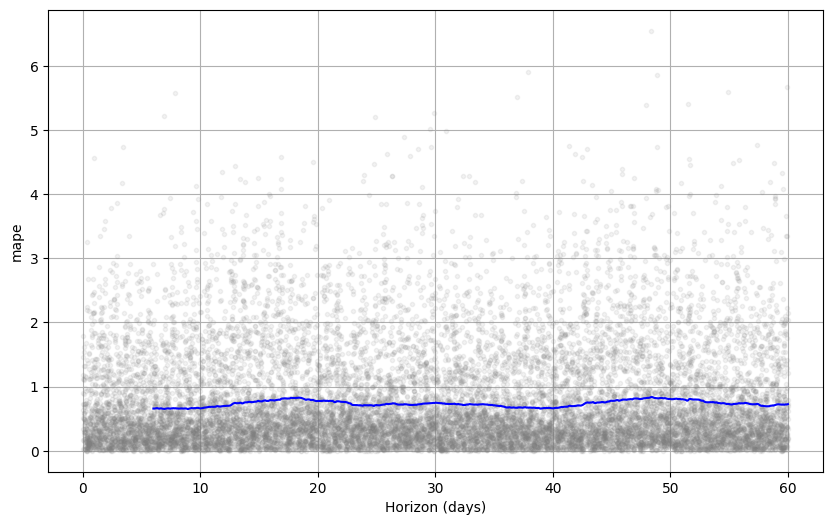

In [ ]:
fig = prophet.plot.plot_cross_validation_metric(df_cv, metric='mape')

# Gráficos

In [ ]:
# Plot con componentes
prophet.plot.plot_components_plotly(model, forecast, uncertainty=True, plot_cap=True)

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  v = v.dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  v = v.dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



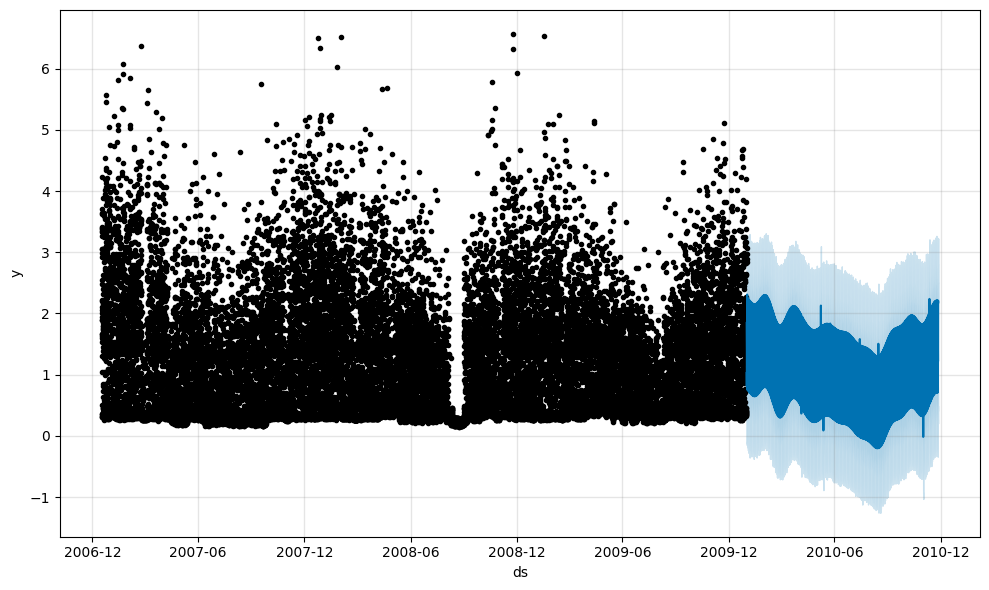

In [ ]:
# plot forecast
model.plot(forecast)
plt.show()

In [ ]:
# Plot interactivo (integrado en prophet)
prophet.plot.plot_plotly(model, forecast)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Plot con componentes
prophet.plot.plot_components_plotly(model, forecast)

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/usr/local/lib/python3.10/dist-packages/

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



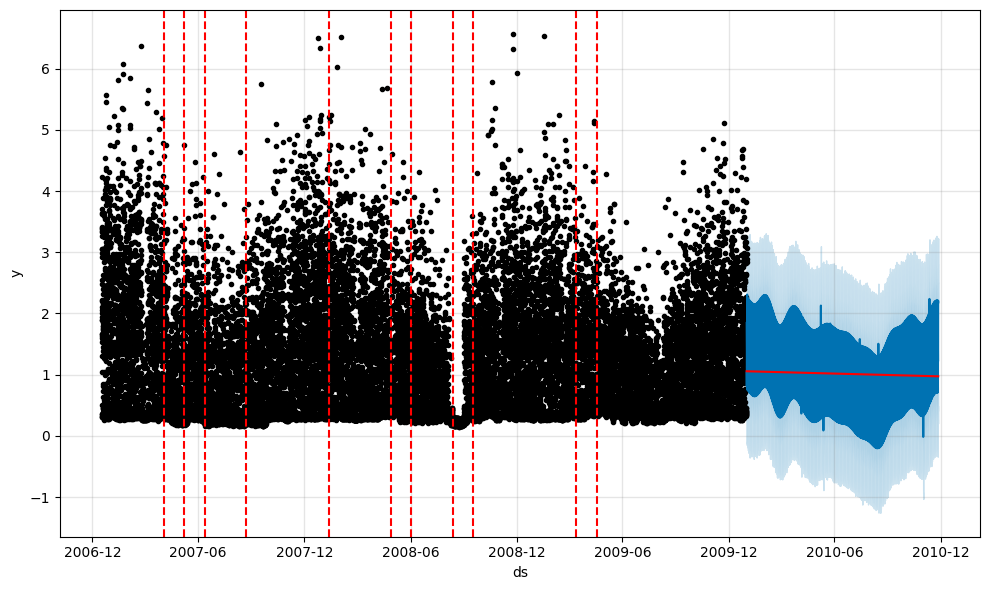

In [ ]:
# Plot con changepoints
fig = model.plot(forecast)
a = prophet.plot.add_changepoints_to_plot(fig.gca(), model, forecast)

# Tuning de hiperparámetros
Si quiero un modelo que se comporte los mejor posible ajustado al dataset que tengo, hay parámetros del mismo que tengo que ajustarlos "a prueba y error". El tuning de hiperparámetros facilita mucho esta tarea: le paso una lista con los todos los valores que quiero evaluar para cada parámetro, y se arma una especie de "grilla" en la que se incluyen todas las combinaciones posibles de los valores que le cargué. Para cada combinación, se hace una validación cruzada y se obtienen las métricas de performance (ejemplo: MAE). Al final, tengo una lista con cada combinación de parámetros y la métrica obtenida para ella, y me quedo con la que da mejor métrica de performance (ese va a ser el mejor modelo para el dataset que tengo)

En [este link](https://facebook.github.io/prophet/docs/diagnostics.html) y en [este otro](https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3) se analiza qué variables conviene tocar, y de qué forma afecta cada una.

>Dejo comentado porque demora mucho. Los parámetros que usé en el modelo son obtenidos luego de haber hecho tuning

In [ ]:
# param_grid = {
#     'seasonality_mode': ['additive','multiplicative'],
#     'daily_seasonality': [10, 15, 20],
#     'yearly_seasonality': [10, 15, 20],
#     #'weekly_seasonality': [True, False]
# }

# # Generate all combinations of parameters
# all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# rmses = []  # Store the RMSEs for each params here

# # Use cross validation to evaluate all parameters
# for params in all_params:
#     m = prophet.Prophet(**params).add_seasonality(name='half_day', period=0.5, fourier_order=5).add_country_holidays(country_name='FR').fit(df)
#     df_cv = prophet.diagnostics.cross_validation(m, initial='730 days', period='180 days', horizon = '365 days', parallel="processes")
#     df_p = prophet.diagnostics.performance_metrics(df_cv, rolling_window=1)
#     rmses.append(df_p['rmse'].values[0])

# # Find the best parameters
# tuning_results = pd.DataFrame(all_params)
# tuning_results['rmse'] = rmses
# print(tuning_results)

In [ ]:
# best_params = all_params[np.argmin(rmses)]
# print(best_params)